#Transfer-learning: ResNet50

#1. Preparación de los datos

In [ ]:
## CARGA DE DATOS
## =============================================================================

!unrar x 'drive/MyDrive/TFM/Datasets/dataset_undersampling.rar'

In [ ]:
## ACELERACIÓN POR GPU
## =============================================================================

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5312719948510596558]

In [ ]:
## Uso de Tensorflow 2.
## =============================================================================

%tensorflow_version 2.x

In [ ]:
## IMPORTACIÓN DE LAS LIBRERIAS NECESARIAS
## =============================================================================

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models    import Sequential, load_model
from tensorflow.keras.layers    import Add, Dense, Activation, GlobalAveragePooling2D, Dropout 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # imprimimos en pantalla el resultado de todos los statements

In [ ]:
## DIRECTORIOS
## =============================================================================

base_dir =  'drive/MyDrive/TFM/Transfer-Learning/ResNet50/'
train_dir = 'dataset_undersampling/train'
test_dir  = 'dataset_undersampling/test'

In [ ]:
## GENERADOR DE IMÁGENES (Ayuda a cargar y transformar las imágenes por lotes )
## =============================================================================

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,                 
        target_size = (224, 224), 
        batch_size  = 32,
        shuffle=False,
        color_mode='rgb',
        class_mode  ='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (224, 224),
        batch_size  = 32,
        shuffle=False,
        color_mode='rgb',
        class_mode  = 'categorical')

Found 13178 images belonging to 4 classes.
Found 3296 images belonging to 4 classes.


#2. ResNet50 (Modelo Base)

In [ ]:
## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
## =============================================================================

base_model = ResNet50(weights="imagenet",
                  include_top=False)

base_model.trainable = False 
               
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir + 'ResNet50_model.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(train_generator, 
                  epochs=60,
                  validation_data=test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'ResNet50_history.npy', history.history)

Epoch 1/60
412/412 [==============================] - 147s 281ms/step - loss: 1.1666 - accuracy: 0.4942 - val_loss: 1.1110 - val_accuracy: 0.4930


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/60
412/412 [==============================] - 114s 276ms/step - loss: 1.0919 - accuracy: 0.5189 - val_loss: 1.0771 - val_accuracy: 0.5042
Epoch 3/60
412/412 [==============================] - 114s 276ms/step - loss: 1.0562 - accuracy: 0.5348 - val_loss: 1.0402 - val_accuracy: 0.5209
Epoch 4/60
412/412 [==============================] - 114s 276ms/step - loss: 1.0293 - accuracy: 0.5498 - val_loss: 1.0162 - val_accuracy: 0.5564
Epoch 5/60
412/412 [==============================] - 114s 276ms/step - loss: 1.0039 - accuracy: 0.5625 - val_loss: 1.0243 - val_accuracy: 0.5467
Epoch 6/60
412/412 [==============================] - 114s 276ms/step - loss: 0.9821 - accuracy: 0.5755 - val_loss: 0.9907 - val_accuracy: 0.5704
Epoch 7/60
412/412 [==============================] - 113s 275ms/step - loss: 0.9635 - accuracy: 0.5883 - val_loss: 0.9548 - val_accuracy: 0.5868
Epoch 8/60
412/412 [==============================] - 113s 275ms/step - loss: 0.9498 - accuracy: 0.5980 - val_loss: 0.9390 -

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'ResNet50_model.h5')
history = np.load(base_dir + 'ResNet50_history.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

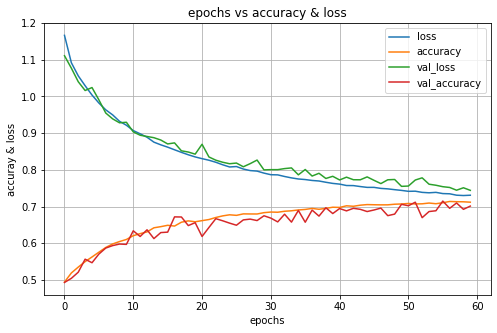

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 23s 223ms/step - loss: 0.7441 - accuracy: 0.7012


In [ ]:
## PREDICCIÓN DEL DATASET DE PRUEBA
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 1, 2, ..., 1, 3, 1])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORÍAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

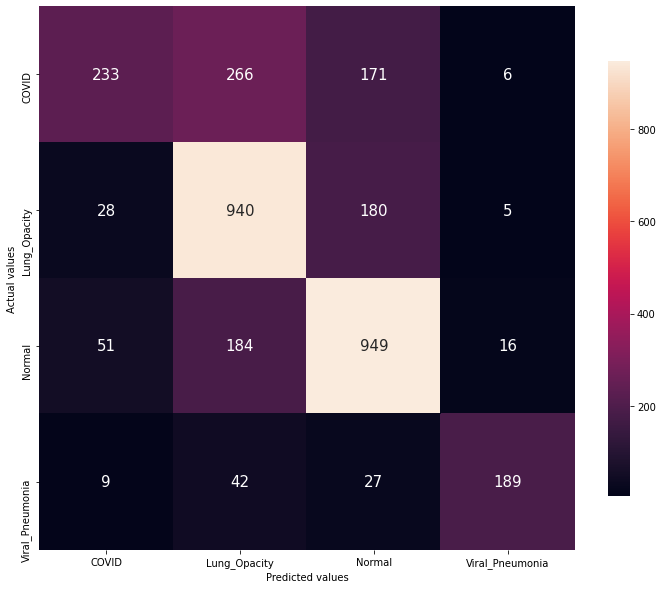

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## =============================================================================

import seaborn as sns

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## METRICAS
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.73      0.34      0.47       676
   Lung_Opacity       0.66      0.82      0.73      1153
         Normal       0.72      0.79      0.75      1200
Viral_Pneumonia       0.88      0.71      0.78       267

       accuracy                           0.70      3296
      macro avg       0.74      0.66      0.68      3296
   weighted avg       0.71      0.70      0.69      3296



#3. ResNet50 (Modelo Base + 2 capas densas)

In [ ]:
## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
## =============================================================================

base_model = ResNet50(weights="imagenet",
                  include_top=False)

base_model.trainable = False                

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir + 'ResNet50_Dense_model.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(train_generator, 
                  epochs=60,
                  validation_data=test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'ResNet50_Dense_history.npy', history.history)

Epoch 1/60
412/412 [==============================] - 157s 303ms/step - loss: 1.2069 - accuracy: 0.4605 - val_loss: 1.1230 - val_accuracy: 0.5115


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/60
412/412 [==============================] - 123s 299ms/step - loss: 1.1206 - accuracy: 0.5000 - val_loss: 1.0609 - val_accuracy: 0.5267
Epoch 3/60
412/412 [==============================] - 124s 300ms/step - loss: 1.1116 - accuracy: 0.5011 - val_loss: 1.0528 - val_accuracy: 0.5285
Epoch 4/60
412/412 [==============================] - 122s 297ms/step - loss: 1.1075 - accuracy: 0.5039 - val_loss: 1.0791 - val_accuracy: 0.5109
Epoch 5/60
412/412 [==============================] - 124s 300ms/step - loss: 1.1181 - accuracy: 0.5004 - val_loss: 1.0595 - val_accuracy: 0.5319
Epoch 6/60
412/412 [==============================] - 122s 296ms/step - loss: 1.0880 - accuracy: 0.5184 - val_loss: 1.0716 - val_accuracy: 0.5437
Epoch 7/60
412/412 [==============================] - 114s 276ms/step - loss: 1.0661 - accuracy: 0.5241 - val_loss: 1.0099 - val_accuracy: 0.5768
Epoch 8/60
412/412 [==============================] - 114s 276ms/step - loss: 1.0634 - accuracy: 0.5330 - val_loss: 1.0111 -

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'ResNet50_Dense_model.h5')
history = np.load(base_dir + 'ResNet50_Dense_history.npy', allow_pickle='TRUE').item()

In [ ]:
## EVALUACIÓN DEL MODELO 
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 24s 234ms/step - loss: 1.1759 - accuracy: 0.4181


In [ ]:
del history['lr']

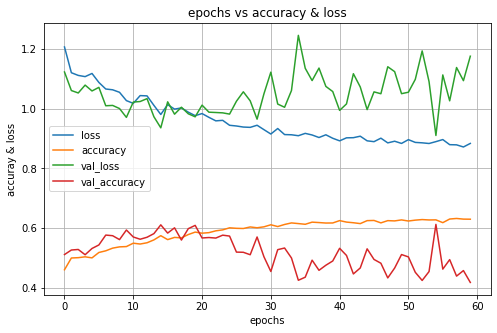

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## PREDICCIÓN DEL MODELO
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([1, 1, 1, ..., 1, 2, 1])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CAREGORIAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

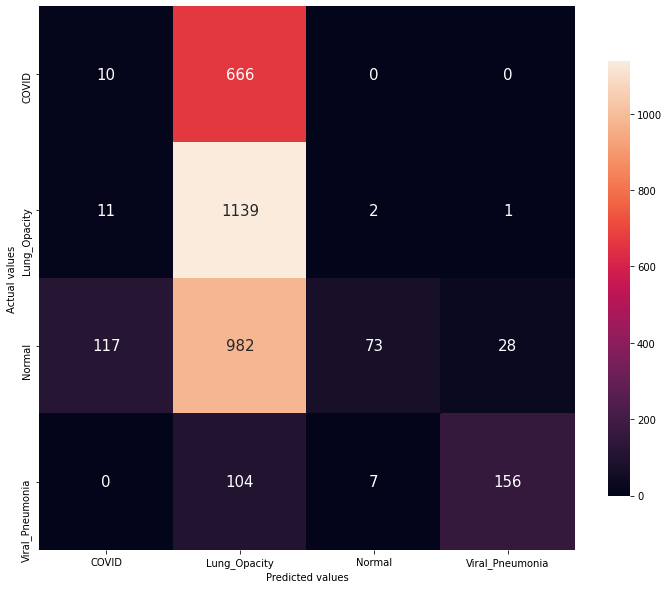

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualización)
## =============================================================================

import seaborn as sns

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## Métricas
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.07      0.01      0.02       676
   Lung_Opacity       0.39      0.99      0.56      1153
         Normal       0.89      0.06      0.11      1200
Viral_Pneumonia       0.84      0.58      0.69       267

       accuracy                           0.42      3296
      macro avg       0.55      0.41      0.35      3296
   weighted avg       0.55      0.42      0.30      3296



#4. ResNet50 (Modelo Base + 2 capas densas + últimas capas adesbloqueadas)

In [ ]:
## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
## =============================================================================

base_model = ResNet50(weights="imagenet",
                  include_top=False)

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
## DESBLOQUEO DE LAS ÚLTIMAS CAPAS CONVOLUCIONALES
## =============================================================================

base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_2_relu', 'conv5_block3_3_conv','conv5_block3_3_bn','conv5_block3_add']:
        layer.trainable = True
    else:
        layer.trainable = False                     

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
## AÑADIDO DE DOS CAPAS DENSAS
## =============================================================================

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

In [ ]:
## COMPILACIÓN DEL MODELO
## =============================================================================

model.compile(loss="categorical_crossentropy",
              optimizer='SGD',
              metrics=["accuracy"])

In [ ]:
## ENTRENAMIENTO DEL MODELO
## =============================================================================

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

checkpoint_cb  = ModelCheckpoint(base_dir + 'ResNet50_Last_Layer_Trainable_model.h5')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.01 * (10 - epoch))

callback_LRS = LearningRateScheduler(scheduler)

history = model.fit(train_generator, 
                  epochs=40,
                  validation_data=test_generator,
                  callbacks=[checkpoint_cb, callback_LRS])

# Guardado del histórico para su posterior recuperación 
np.save(base_dir + 'ResNet50_Last_Layer_Trainable_history.npy', history.history)

Epoch 1/40
412/412 [==============================] - 123s 286ms/step - loss: 1.2727 - accuracy: 0.4130 - val_loss: 1.1391 - val_accuracy: 0.5252


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
412/412 [==============================] - 117s 285ms/step - loss: 1.1295 - accuracy: 0.4952 - val_loss: 1.0367 - val_accuracy: 0.5440
Epoch 3/40
412/412 [==============================] - 117s 284ms/step - loss: 1.0611 - accuracy: 0.5281 - val_loss: 0.9849 - val_accuracy: 0.5619
Epoch 4/40
412/412 [==============================] - 117s 284ms/step - loss: 0.9981 - accuracy: 0.5696 - val_loss: 0.9617 - val_accuracy: 0.5631
Epoch 5/40
412/412 [==============================] - 117s 284ms/step - loss: 0.9405 - accuracy: 0.6057 - val_loss: 0.9635 - val_accuracy: 0.5771
Epoch 6/40
412/412 [==============================] - 117s 284ms/step - loss: 0.8888 - accuracy: 0.6277 - val_loss: 0.8427 - val_accuracy: 0.6341
Epoch 7/40
412/412 [==============================] - 117s 284ms/step - loss: 0.8430 - accuracy: 0.6521 - val_loss: 0.9064 - val_accuracy: 0.6044
Epoch 8/40
412/412 [==============================] - 117s 284ms/step - loss: 0.8117 - accuracy: 0.6654 - val_loss: 0.8294 -

In [ ]:
## RECUPERACIÓN DEL MODELO E HISTÓRICO
## =============================================================================

model   = load_model(base_dir + 'ResNet50_Last_Layer_Trainable_model.h5')
history = np.load(base_dir + 'ResNet50_Last_Layer_Trainable_history.npy', allow_pickle='TRUE').item()

In [ ]:
del history['lr']

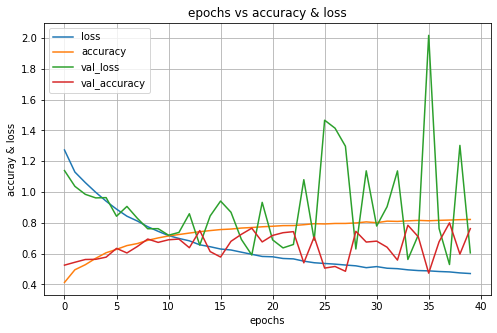

In [ ]:
## REPRESENTACIÓN GRÁFICA
## =============================================================================

pd.DataFrame(history).plot(figsize=(8, 5))
plt.title('epochs vs accuracy & loss')
plt.xlabel('epochs')
plt.ylabel('accuray & loss')
#plt.ylim(0,1)
plt.grid(True)
plt.savefig(base_dir + 'learning_curves_model');

In [ ]:
## EVALUACIÓN DEL MODELO
## =============================================================================

result_train = model.evaluate(train_generator)
result_test = model.evaluate(test_generator)

103/103 [==============================] - 23s 221ms/step - loss: 0.6048 - accuracy: 0.7621


In [ ]:
## PREDICCIÓN DEL MODELO
## =============================================================================

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_pred

array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
## MATRIZ DE CONFUSIÓN
## =============================================================================

y_test  = test_generator.classes
confusion = confusion_matrix(y_test, y_pred)

In [ ]:
## CATEGORIAS
## =============================================================================

class_names = test_generator.class_indices.keys()
class_names

dict_keys(['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia'])

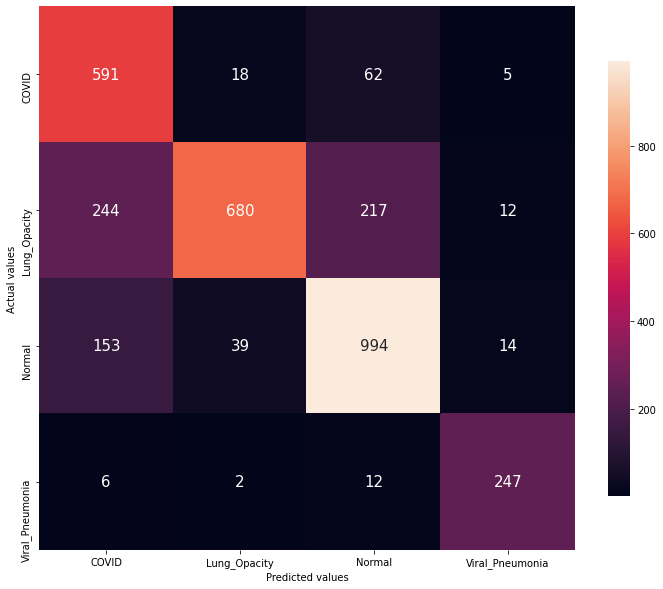

In [ ]:
## MATRIZ DE CONFUSIÓN (Visualizacion)
## =============================================================================
import seaborn as sns

cm = pd.DataFrame(confusion, range(4), range(4))

plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True, 
             fmt='.4g',
             annot_kws   = {"size": 15},
             cbar_kws    = {"shrink": .8},
             xticklabels = class_names, 
             yticklabels = class_names);
plt.xlabel("Predicted values")
plt.ylabel("Actual values");

In [ ]:
## Métricas
## =============================================================================

print(classification_report(test_generator.classes, y_pred, target_names=class_names));

                 precision    recall  f1-score   support

          COVID       0.29      0.99      0.45       724
   Lung_Opacity       0.88      0.24      0.37      1203
         Normal       0.90      0.55      0.68      2039
Viral_Pneumonia       0.85      0.68      0.76       269

       accuracy                           0.54      4235
      macro avg       0.73      0.62      0.57      4235
   weighted avg       0.79      0.54      0.56      4235

